In [9]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import numpy as np
import seaborn as sns
from nilearn import plotting
import nibabel as nib
import itertools
from bold_dementia.connectivity import Atlas, group_by_networks, plot_matrix, reshape_pvalues, block_block
from bold_dementia.utils.iterables import unique

ATLAS = "gillig-regions"
SOFT = False
ALPHA = config["alpha"]
atlas = Atlas.from_name(ATLAS, soft=SOFT)
labels = tuple(sorted(unique(atlas.macro_labels)))

In [10]:
expname = f"atlas-{ATLAS}_merged_ols-cenanom-block"
matrices_path = Path(
    f"{config['output_dir']}/statresults/{expname}"
)

resdf = pd.read_csv(matrices_path / "resdf.csv", index_col=0)
resdf["node_a"] = resdf["edges"].map(lambda edge: edge.split("_")[0])
resdf["node_b"] = resdf["edges"].map(lambda edge: edge.split("_")[1])

mask = np.where(resdf["pvalues_fdr"] < ALPHA, 1, 0) 
resdf["thresholded_beta"] = resdf["beta_AD"] * mask

resdf = resdf.drop("edges", axis=1)

resdf_pv = resdf.pivot(index="node_a" ,columns=["node_b"], values=["beta_AD", "pvalues_raw", "pvalues_fdr", "thresholded_beta"])

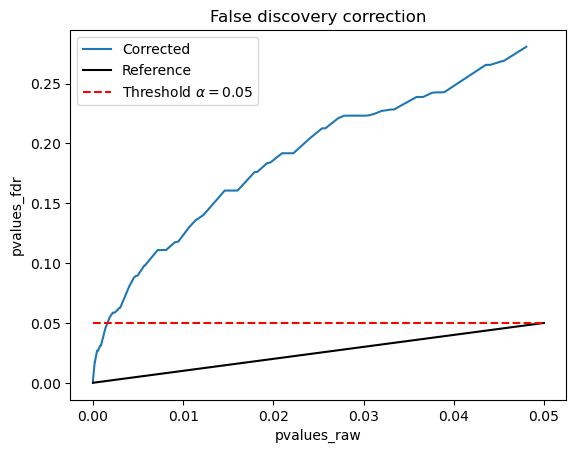

In [11]:
x = np.linspace(0, ALPHA, 100)

sns.lineplot(
    resdf[resdf.pvalues_raw <= ALPHA].sort_values(by="pvalues_raw"),
    x="pvalues_raw", y="pvalues_fdr", label="Corrected",
    markers="x"
)
plt.plot(x, x, color="black", label="Reference")
plt.hlines(
    y=ALPHA,
    xmin=0,
    xmax=ALPHA,
    colors="red", 
    label=f"Threshold $\\alpha = {ALPHA}$",
    linestyles="--"
)
plt.title(f"False discovery correction")
plt.legend()
plt.show()

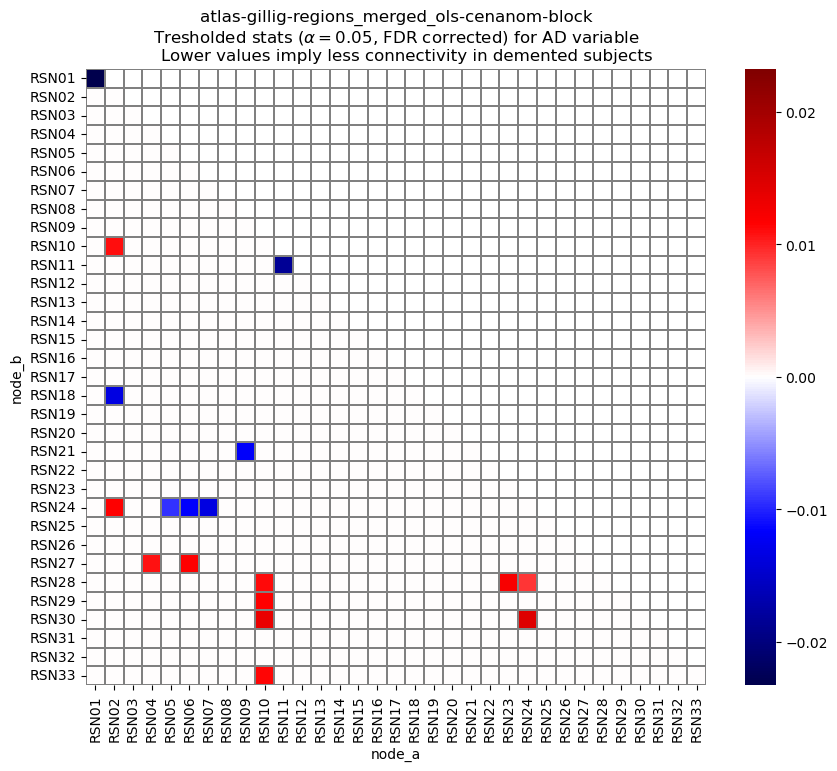

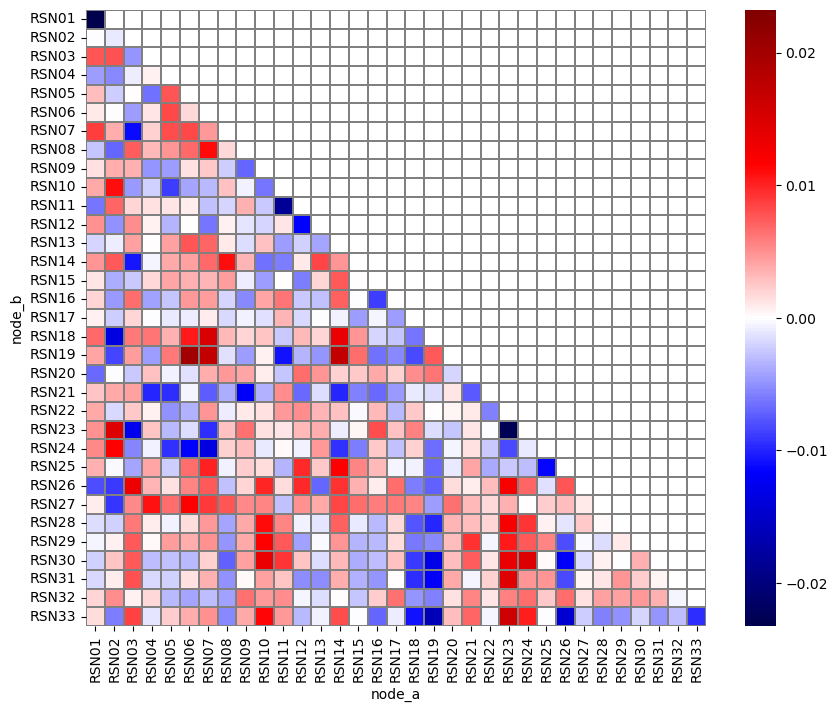

In [12]:
span = max(
    resdf["thresholded_beta"].min().__abs__(),
    resdf["thresholded_beta"].max().__abs__()
)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(
    resdf_pv.loc[:, "thresholded_beta"].T,
    vmin=-span, vmax=span, cmap="seismic", linewidths=0.1, linecolor="gray"
)
plt.title(f"{expname}\nTresholded stats ($\\alpha = 0.05$, FDR corrected) for AD variable\n\
    Lower values imply less connectivity in demented subjects")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(
    resdf_pv.loc[:, "beta_AD"].T,
    vmin=-span, vmax=span, cmap="seismic", linewidths=0.1, linecolor="gray"
)

plt.show()

In [13]:
if ATLAS == "gillig-regions":
    atlas.labels_.pop(0)
    df = pd.DataFrame(atlas)

In [14]:
s = df[df.networks == "RSN22"].iloc[0, :]
print(s["CogAtlas definition"])

The ability to understand communication from others, such as speech, written text, gestures, or sign language.


In [15]:
s

maps                              /bigdata/jlegrand/data/Memento/atlas/M5_no-tru...
labels                                                                 L-FPN-VI_001
networks                                                                      RSN22
description                       Experimental atlas of resting state networks w...
RSN                                                                              27
icol                                                                              1
nvoxel                                                                           33
tissue                                                                       cortex
itissue                                                                           1
min                                                                        3.294762
max                                                                        4.730757
hout                                                                        